In [1]:
import sys
print(f'Working with Python {sys.version}')

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import numpy as np
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')



# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
import fiora.IO.mspReader as mspReader
import fiora.IO.mgfReader as mgfReader
import fiora.visualization.spectrum_visualizer as sv


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


In [2]:
version = "v6"
path: str = f"{home}/data/metabolites/MSnLib/{version}/" 

dfs = []
for filename in os.listdir(path):
    if filename.endswith("ms2.mgf"):
        filepath = path + filename
        print(f"Reading {filename}")
        df = pd.DataFrame(mgfReader.read(path + filename))
        df["file"] = filename
        df["lib"] = "MSnLib"
        df["origin"] = filename.split("_")[1]
        dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True)

Reading 20250228_targetmolnphts_pos_ms2.mgf
Reading 20241003_otavapep_pos_ms2.mgf
Reading 20241003_nihnp_neg_ms2.mgf
Reading 20241003_enamdisc_pos_ms2.mgf
Reading 20241003_mcebio_pos_ms2.mgf
Reading 20241003_mcescaf_pos_ms2.mgf
Reading 20241003_mcescaf_neg_ms2.mgf
Reading 20241003_nihnp_pos_ms2.mgf
Reading 20241003_enamdisc_neg_ms2.mgf
Reading 20241003_mcedrug_pos_ms2.mgf
Reading 20241003_mcebio_neg_ms2.mgf
Reading 20241003_otavapep_neg_ms2.mgf
Reading 20241003_mcedrug_neg_ms2.mgf
Reading 20241003_enammol_pos_ms2.mgf
Reading 20241003_enammol_neg_ms2.mgf
Reading 20250228_mcediv_50k_sub_pos_ms2.mgf
Reading 20250228_mcediv_50k_sub_neg_ms2.mgf
Reading 20250228_targetmolnphts_np_neg_ms2.mgf


In [3]:
print(f"Total number of data entries: {len(df)}")

Total number of data entries: 563294


In [4]:
delim = ", " if version == "v5" else ","
df["CE_steps"] = df["COLLISION_ENERGY"].apply(
    lambda x: [float(v) for v in x.strip("[]").split(delim)] if "[" in x else [float(x)]
)
df["Num_steps"] = df["CE_steps"].apply(len)
df["CE"] = df["CE_steps"].apply(lambda x: sum(x) / len(x))


In [5]:
df[df["Num_steps"] == 6]["CE_steps"].head(2)

78038     [20.0, 45.0, 60.0, 40.0, 15.0, 30.0]
123741    [20.0, 45.0, 60.0, 40.0, 15.0, 30.0]
Name: CE_steps, dtype: object

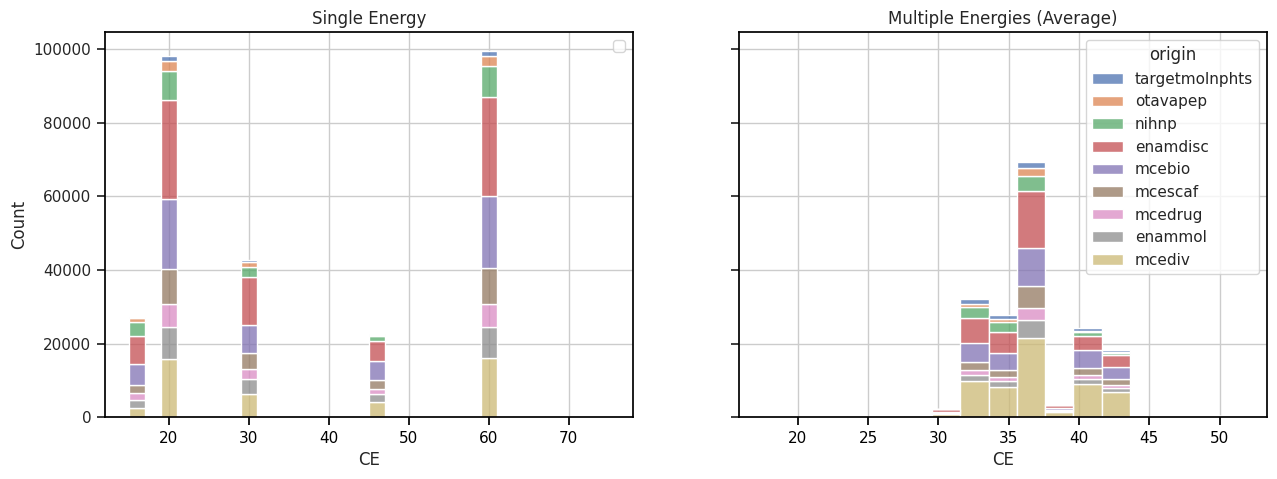

In [6]:
from fiora.visualization.define_colors import *
set_light_theme()
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)


sns.histplot(ax=axs[0], data=df[df["SPECTYPE"].isin(["SINGLE_BEST_SCAN", "SAME_ENERGY"])], x="CE", hue="origin", multiple="stack", binwidth=2)
sns.histplot(ax=axs[1], data=df[df["SPECTYPE"].isin(["ALL_ENERGIES", "ALL_MSN_TO_PSEUDO_MS2"])], x="CE", hue="origin", multiple="stack", binwidth=2)
axs[0].set_title("Single Energy")
axs[0].legend("")
axs[1].set_title("Multiple Energies (Average)")
plt.show()


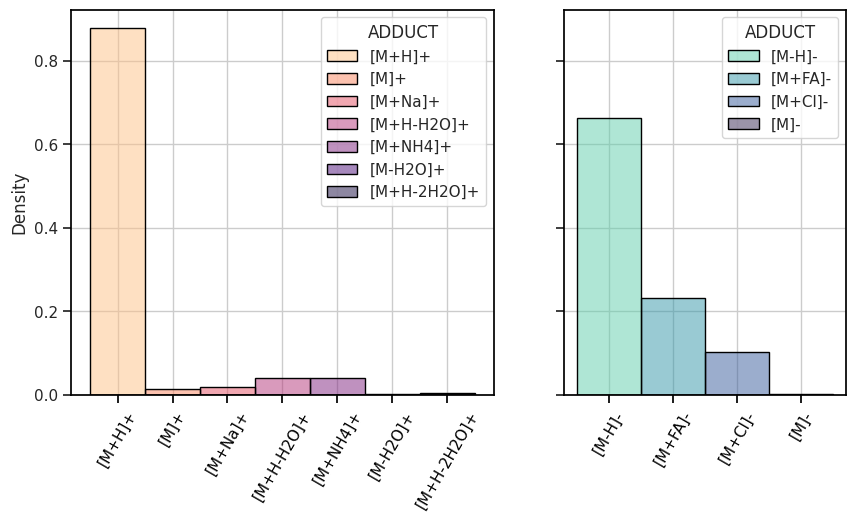

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.5, 1]}, sharey=True)
#plt.subplots_adjust(wspace=0.1, hspace=0.05)

sns.histplot(ax=axs[0], data=df[df["IONMODE"] == "Positive"], x="ADDUCT", palette=magma(7), hue="ADDUCT", edgecolor="black", stat="density")
axs[0].tick_params(axis='x', rotation=60)
axs[0].set_xlabel("")
sns.histplot(ax=axs[1], data=df[df["IONMODE"] == "Negative"], x="ADDUCT", palette=sns.color_palette("mako_r", 4), hue="ADDUCT", edgecolor="black", stat="density")
axs[1].set_xlabel("")
axs[1].tick_params(axis='x', rotation=60)
plt.show()

In [8]:
from fiora.MOL.Metabolite import Metabolite
from fiora.MOL.constants import PPM
PPM_NUM: int = 10
TOLERANCE = PPM_NUM * PPM

In [9]:
df["PPM_num"] = PPM_NUM
df["ppm_peak_tolerance"] = TOLERANCE
df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
_ = df["Metabolite"].apply(lambda x: x.compute_graph_attributes(memory_safe=False)) # Set memory_safe=False if necessary

In [10]:
from fiora.MOL.MetaboliteIndex import MetaboliteIndex

mindex: MetaboliteIndex = MetaboliteIndex()
mindex.index_metabolites(df["Metabolite"])

In [11]:
mindex.create_fragmentation_trees()

In [12]:
list_of_mismatched_ids = mindex.add_fragmentation_trees_to_metabolite_list(df["Metabolite"], graph_mismatch_policy="recompute")
print(f"Total number of recomputed trees: {len(list_of_mismatched_ids)}")

Total number of recomputed trees: 6538


In [13]:
df["group_id"] = df["Metabolite"].apply(lambda x: x.get_id())
df["num_per_group"] = df["group_id"].map(df["group_id"].value_counts())
for i, data in df.iterrows():
    data["Metabolite"].set_loss_weight(1.0 / data["num_per_group"])
df["loss_weight"] = df["Metabolite"].apply(lambda x: x.loss_weight)
print(f"Number of metabolites in index: {mindex.get_number_of_metabolites()}")

def print_df_stats(df):
    num_spectra = df.shape[0]
    num_ids = len(df["group_id"].unique())
    
    print(f"Dataframe stats: {num_spectra} spectra covering {num_ids} unique structures")


print_df_stats(df)

Number of metabolites in index: 47181
Dataframe stats: 563294 spectra covering 47181 unique structures


In [14]:
_ = df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE, match_stats_only=True), axis=1)

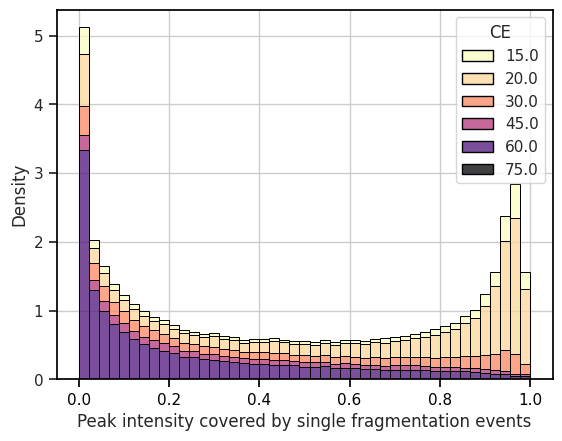

In [15]:
df["coverage"] = df["Metabolite"].apply(lambda x: x.match_stats["coverage"])
sns.histplot(data=df[df["SPECTYPE"].isin(["SINGLE_BEST_SCAN", "SAME_ENERGY"])], x="coverage", hue="CE", palette="magma_r", edgecolor="black", multiple="stack", stat="density", hue_norm=(df["CE"].min(), df["CE"].max()))
plt.xlabel("Peak intensity covered by single fragmentation events")

plt.show()


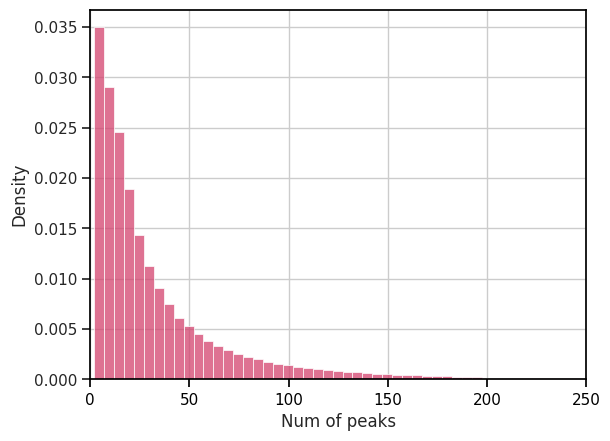

In [16]:
df["Num peaks"] = df["Num peaks"].astype(int)
sns.histplot(df, x="Num peaks", color=magma(6)[2], multiple="stack", stat="density", binwidth=5, edgecolor="white", linewidth=0.5)
plt.xlabel("Num of peaks")
plt.xlim(0,250)
plt.show()

### Begin filtering

First, we establish consitent names and data types with the other datasets. Then, a first round of basic filters are applied addressing precursor types, molecualar weight, and collision energies. 

In [17]:
cast_float = ["PEPMASS", "RTINSECONDS"]
df[cast_float] = df[cast_float].astype(float)
df["ionization"] = "ESI"
df["instrument"] = "HCD"
df["Precursor_type"] = df["ADDUCT"]

In [18]:
# TODO HERE #%%capture
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.CovariateFeatureEncoder import CovariateFeatureEncoder

metadata_key_map = {
                "name": "NAME",
                "collision_energy":  "CE", 
                "instrument": "instrument",
                "ionization": "ionization",
                "precursor_mz": "PEPMASS",
                "precursor_mode": "Precursor_type",
                "retention_time": "RTINSECONDS",
                "ce_steps": "CE_steps"
                }

filter_spectra = True
CE_upper_limit = 100.0
weight_upper_limit = 1000.0
allowed_precursor_modes = ["[M+H]+", "[M-H]-", "[M]+", "[M]-"]


node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = CovariateFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = CovariateFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

if filter_spectra:
    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

if filter_spectra:
    df = df[df['ADDUCT'].isin(allowed_precursor_modes)]
    num_ori = df.shape[0]
    correct_energy = df["Metabolite"].apply(lambda x: x.metadata["collision_energy"] <= CE_upper_limit and x.metadata["collision_energy"] > 1) 
    df = df[correct_energy]
    correct_weight = df["Metabolite"].apply(lambda x: x.metadata["molecular_weight"] <= weight_upper_limit)
    df = df[correct_weight]    
    print(f"Filtering spectra ({num_ori}) down to {df.shape[0]}")
    #df = df[df["SPECTYPE"] != "ALL_ENERGIES"]
    #print(df["Precursor_type"].value_counts())


Filtering spectra (452628) down to 450868


In [19]:
df["SPECTYPE"].value_counts(dropna=False)

SPECTYPE
SINGLE_BEST_SCAN         131669
SAME_ENERGY              107241
SINGLE_SCAN               74302
ALL_ENERGIES              69270
ALL_MSN_TO_PSEUDO_MS2     68386
Name: count, dtype: int64

In [20]:
s_same = set(df[df["SPECTYPE"] == "SAME_ENERGY"].group_id.unique())
s_all = set(df[df["SPECTYPE"] == "ALL_ENERGIES"].group_id.unique())
s_pseudo = set(df[df["SPECTYPE"] == "ALL_MSN_TO_PSEUDO_MS2"].group_id.unique())
print("Num values in s_same:", len(s_same))
print("Num values in s_all:", len(s_all))
print("Num values in s_pseudo:", len(s_pseudo))

Num values in s_same: 30996
Num values in s_all: 45652
Num values in s_pseudo: 45413


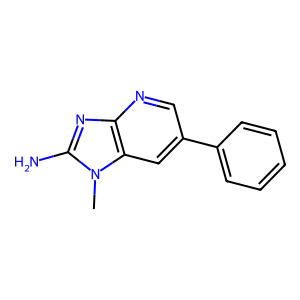

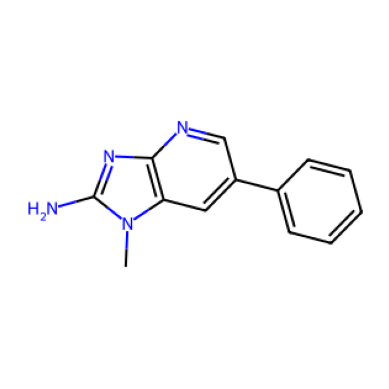

In [27]:
df["Metabolite"].iloc[0].draw()

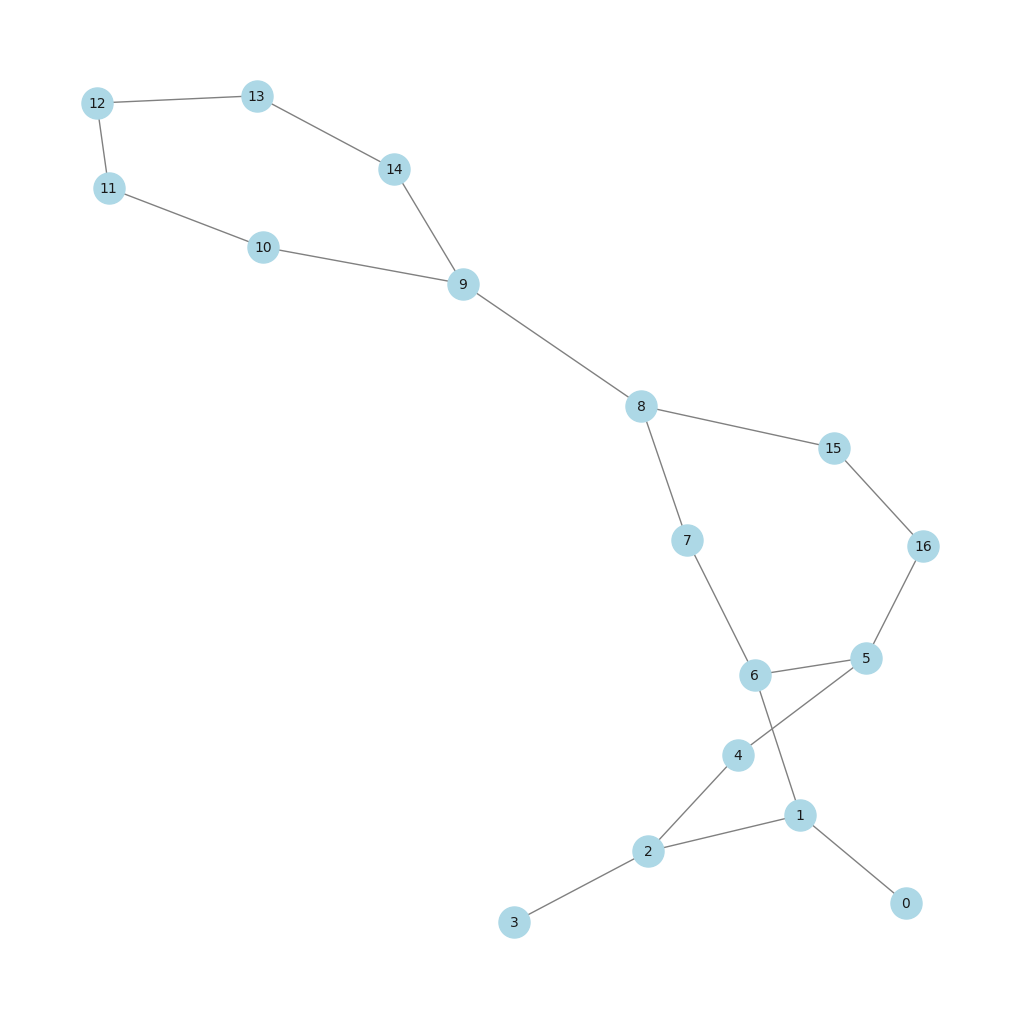

In [38]:
import networkx as nx
from matplotlib import pyplot as plt

df["Metabolite"].iloc[0].Graph

graph = df["Metabolite"].iloc[0].Graph
plt.figure(figsize=(10, 10))
nx.draw(graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.show()

In [46]:
df["Metabolite"].iloc[0].fragmentation_tree.get_all_fragments()

[<Fragment Object> :: Cn1c(N)nc2ncc(-c3ccccc3)cc21,
 <Fragment Object> :: Cn1cnc2ncc(-c3ccccc3)cc21,
 <Fragment Object> :: N,
 <Fragment Object> :: Cn1c(N)nc2ncccc21,
 <Fragment Object> :: c1ccccc1]

In [45]:
f = 3
print(df["Metabolite"].iloc[0].fragmentation_tree.get_all_fragments()[f])
df["Metabolite"].iloc[0].fragmentation_tree.get_all_fragments()[f].subgraphs

<Fragment Object> :: Cn1c(N)nc2ncccc21


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16]]

In [21]:
raise KeyboardInterrupt() #TODO continue here

KeyboardInterrupt: 

##### Identify and Export Molecules with Potential Ring Cleavages

In [ ]:
# TODO run this
ring_condition = df["Metabolite"].apply(lambda x: (x.match_stats["coverage"] < 0.5) & bool(x.ring_proportion > 0.8))
df_rings = df[ring_condition]

# TODO continue

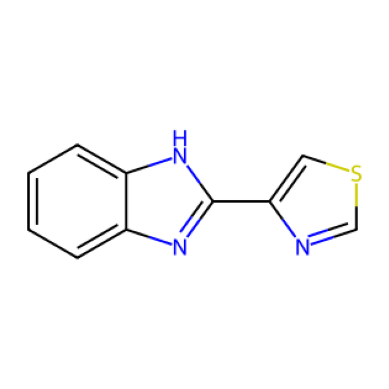

In [ ]:
for i, d in df_rings.head(1).iterrows():
    d["Metabolite"].draw()
    plt.show()

In [ ]:
save_rings: bool = False
if save_rings:
    path: str = f'{home}/data/metabolites/preprocessed/rings_msnlib.csv'
    print(f"Saving ring dataframe to {path}")
    df_rings.to_csv(path)

In [54]:
df_backup = df.copy(deep=True)

In [55]:
from typing import Dict

# Hard filter conditions that must be fulfilled
hard_filters : Dict[str, int] = {
    "min_peaks": 2,
    "min_coverage": 0.5,
    "max_precursor_intensity": 0.9,
}

# Soft conditions where at least one must be met
soft_filters : Dict[str, int] = {
    "desired_peaks": 4,
    "desired_coverage": 0.75,
    "desired_peak_percentage": 0.5, # Proportion of peaks covered by the fragmentation
}

hard_filters_drops : Dict[str, list] = {key: [] for key in hard_filters.keys()}
soft_filters_keeps : Dict[str, list] = {key: [] for key in soft_filters.keys()}

In [56]:
drop_indices = []
for i, data in df.iterrows():
    M = data["Metabolite"]
    
    hard_filter_pass = True
    # Hard filters
    if M.match_stats["num_peak_matches_filtered"] < hard_filters["min_peaks"]:
        hard_filter_pass = False
        hard_filters_drops["min_peaks"].append(i)
    if M.match_stats["coverage"] < hard_filters["min_coverage"]:
        hard_filter_pass = False
        hard_filters_drops["min_coverage"].append(i)
    if M.match_stats["precursor_prob"] > hard_filters["max_precursor_intensity"]:
        hard_filter_pass = False
        hard_filters_drops["max_precursor_intensity"].append(i)
    
    if not hard_filter_pass:
        drop_indices.append(i)
        continue

    # Soft filters
    # Either condition is enough to keep the spectrum
    soft_filter_pass = False
    if M.match_stats["num_peak_matches_filtered"] >= soft_filters["desired_peaks"]:
        soft_filter_pass = True
        soft_filters_keeps["desired_peaks"].append(i)
    if M.match_stats["percent_peak_matches_filtered"] >= soft_filters["desired_peak_percentage"]:
        soft_filter_pass = True
        soft_filters_keeps["desired_peak_percentage"].append(i)
    if M.match_stats["coverage"] >= soft_filters["desired_coverage"]:
        soft_filter_pass = True
        soft_filters_keeps["desired_coverage"].append(i)
        
        
    if not soft_filter_pass:
        drop_indices.append(i)


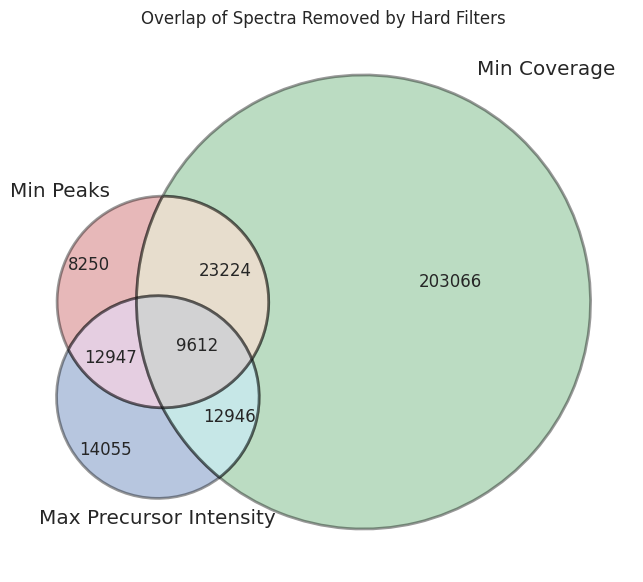

In [57]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Extract the sets and labels from the dictionary
sets = [set(hard_filters_drops[key]) for key in hard_filters_drops]
key_to_label = {
    "min_peaks": "Min Peaks",
    "min_coverage": "Min Coverage",
    "max_precursor_intensity": "Max Precursor Intensity"
}
labels = [key_to_label[key] for key in hard_filters_drops.keys()]

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(sets, labels)

# Customize the Venn diagram with thicker lines and black edges
for subset in venn.patches:
    if subset:  # Check if the subset exists (not None)
        subset.set_linewidth(2)  # Set line thickness
        subset.set_edgecolor('black')  # Set edge color to black



# Add a title
plt.title("Overlap of Spectra Removed by Hard Filters")
plt.show()

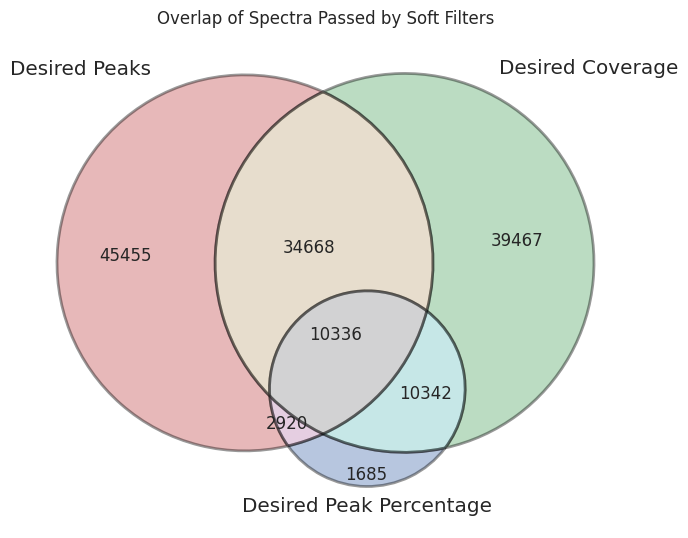

In [58]:
sets = [set(soft_filters_keeps[key]) for key in soft_filters_keeps]
key_to_label = {
    "desired_peaks": "Desired Peaks",
    "desired_coverage": "Desired Coverage",
    "desired_peak_percentage": "Desired Peak Percentage"
}
labels = [key_to_label[key] for key in soft_filters_keeps.keys()]

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(sets, labels)

# Customize the Venn diagram with thicker lines and black edges
for subset in venn.patches:
    if subset:  # Check if the subset exists (not None)
        subset.set_linewidth(2)  # Set line thickness
        subset.set_edgecolor('black')  # Set edge color to black

# Add a title
plt.title("Overlap of Spectra Passed by Soft Filters")
plt.show()

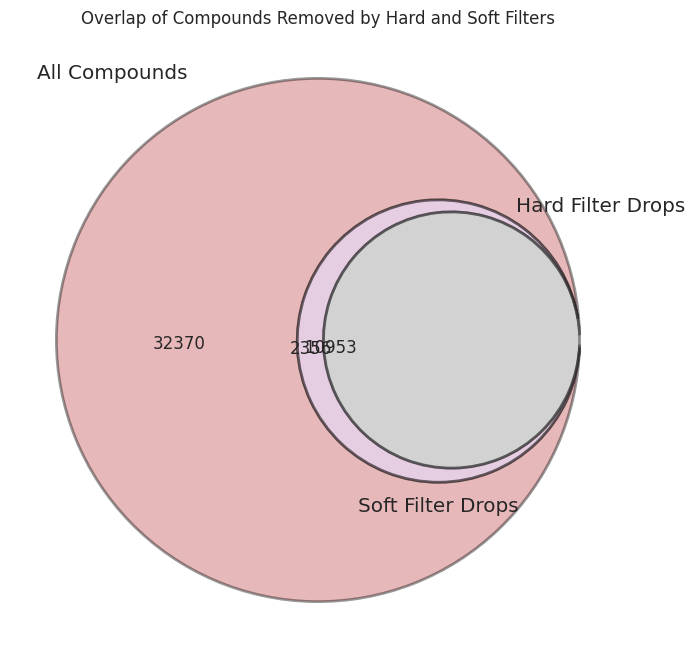

In [59]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Convert spectral indices to group IDs
group_ids = df['group_id'].unique()

# Identify compounds completely removed by hard filters
hard_filter_indices = set()
for indices in hard_filters_drops.values():
    hard_filter_indices.update(indices)

compounds_removed_by_hard_filters = {
    group_id for group_id in group_ids
    if all(idx in hard_filter_indices for idx in df[df['group_id'] == group_id].index)
}

# Identify compounds removed by soft filters (or hard filters)
soft_filter_indices = set(drop_indices) - hard_filter_indices
compounds_removed_by_soft_filters = {
    group_id for group_id in group_ids
    if all(idx in hard_filter_indices or idx in soft_filter_indices for idx in df[df['group_id'] == group_id].index)
}

# All group IDs
all_compounds = set(group_ids)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(
    [all_compounds, compounds_removed_by_hard_filters, compounds_removed_by_soft_filters],
    ('All Compounds', 'Hard Filter Drops', 'Soft Filter Drops')
)

# Customize the Venn diagram with thicker lines and black edges
for subset in venn.patches:
    if subset:  # Check if the subset exists (not None)
        subset.set_linewidth(2)  # Set line thickness
        subset.set_edgecolor('black')  # Set edge color to black

# Add a title
plt.title("Overlap of Compounds Removed by Hard and Soft Filters")
plt.show()

In [60]:
print_df_stats(df)
drop_indices = np.unique(drop_indices)
print(f"Filtering out {len(drop_indices)} that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible")
df = df.drop(drop_indices)
print_df_stats(df)

Dataframe stats: 450868 spectra covering 45679 unique structures
Filtering out 305995 that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible
Dataframe stats: 144873 spectra covering 32370 unique structures


<Axes: xlabel='coverage', ylabel='Count'>

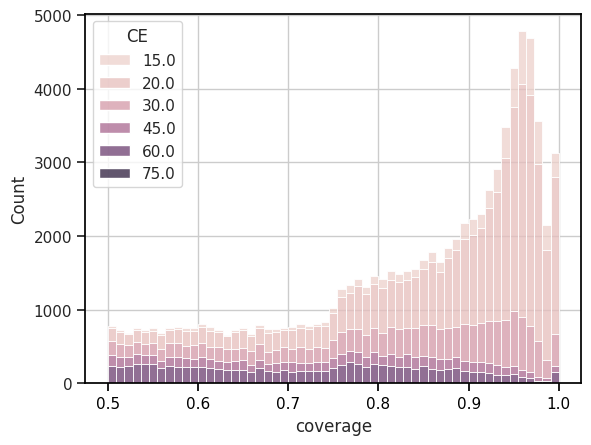

In [62]:
sns.histplot(df[df["SPECTYPE"].isin(["SAME_ENERGY", "SINGLE_BEST_SCAN"], )], x= "coverage", hue="CE", multiple="stack")

### Align train/test sets with other (previous) test datasets

Load other test data and enforce matching MSnLib compounds to be mapped to the respective test/validation splits before applying random datasplits

In [63]:
from fiora.IO.LibraryLoader import LibraryLoader


train_ids, va_ids, test_ids = [], [], []

L = LibraryLoader()
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"
df_merged = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv")
df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)
df_cast = pd.read_csv(f"{home}/data/metabolites/CASMI_2016/casmi16t_withCCS.csv", index_col=[0], low_memory=False)

other_dfs = {
    "train": df_merged[df_merged["dataset"] == "training"].drop_duplicates(subset=["group_id"]),
    "val": df_merged[df_merged["dataset"] == "validation"].drop_duplicates(subset=["group_id"]),
    "test": pd.concat([df_merged[df_merged["dataset"] == "test"].drop_duplicates(subset=["group_id"]), df_cas, df_cast, df_cas22]).drop_duplicates(subset=["SMILES"]),
}

In [64]:
lookup_table = {
    "train": set(),
    "val": set(),
    "test": set()
}
for key, df_x in other_dfs.items():
     df_x["Metabolite"] = df_x["SMILES"].apply(Metabolite)
     
     for i, data in df_x.iterrows():
         lookup_table[key].add((data["Metabolite"].ExactMolWeight, data["Metabolite"].morganFingerCountOnes))
     

In [65]:
train, val, test = [], [], []


for id in df["group_id"].unique():
    metabolite: Metabolite = df[df["group_id"] == id].iloc[0]["Metabolite"]
    fast_identifiers = (metabolite.ExactMolWeight, metabolite.morganFingerCountOnes)
    found_match = False
    
    if fast_identifiers in lookup_table["train"]:
        for i, data in other_dfs["train"].iterrows():
            other_metabolite = data["Metabolite"]
            if metabolite == other_metabolite:
                train.append(id)
                found_match = True
                break
    if not found_match and fast_identifiers in lookup_table["val"]:
        for i, data in other_dfs["val"].iterrows():
            other_metabolite = data["Metabolite"]
            if metabolite == other_metabolite:
                val.append(id)
                break
    if not found_match and fast_identifiers in lookup_table["test"]:
            for i, data in other_dfs["test"].iterrows():
                other_metabolite = data["Metabolite"]
                if metabolite == other_metabolite:
                    test.append(id)
                    break

In [66]:
print(f"Preset compounds assigned to datasplits: {len(train)=} {len(val)=} {len(test)=}")
print(f"{train[:5]=} {val[-5:]=} {test[5:10]=}")

Preset compounds assigned to datasplits: len(train)=1167 len(val)=125 len(test)=200
train[:5]=[np.int64(17), np.int64(29), np.int64(50), np.int64(61), np.int64(63)] val[-5:]=[np.int64(30328), np.int64(798), np.int64(46958), np.int64(417), np.int64(47144)] test[5:10]=[np.int64(543), np.int64(657), np.int64(880), np.int64(940), np.int64(1045)]


In [67]:
from sklearn.model_selection import train_test_split

def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=42):
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys


In [68]:
group_ids = df["group_id"].astype(int)
keys = np.unique(group_ids)
num_keys = len(keys)
mask = ~np.isin(keys, train + val + test)
unassigned_keys = keys[mask]
num_unassigned = len(unassigned_keys)

desired_split_size = int(num_keys * 0.1)
test_size_remaining = desired_split_size - len(test)
val_size_remaining = desired_split_size - len(val)

test_new_frac = test_size_remaining / num_unassigned
val_new_frac = val_size_remaining / num_unassigned
train_add, val_add, test_add = train_val_test_split(unassigned_keys, test_size=test_new_frac, val_size=val_new_frac)
train = np.concatenate((np.array(train), train_add))
val = np.concatenate((np.array(val), val_add))
test = np.concatenate((np.array(test), test_add))


df["dataset"] = df["group_id"].apply(lambda x: 'training' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')
df["datasplit"] = df["dataset"]

In [69]:
print(f"Unique compounds in each {df.groupby('datasplit')['group_id'].nunique()}")

Unique compounds in each datasplit
test           3237
training      25896
validation     3237
Name: group_id, dtype: int64


### Save datasplits and metadata

In [ ]:
raise KeyboardInterrupt("Stop before saving")

KeyboardInterrupt: Stop before saving

In [ ]:
save_df: bool = False
if save_df:
    path: str = f'{home}/data/metabolites/preprocessed/datasplits_msnlib_v6_July25.csv' # Save with merge spectra (4)
    print(f"Saving datasplits to {path}")
    df.to_csv(path)

Saving datasplits to /home/ynowatzk/data/metabolites/preprocessed/datasplits_msnlib_v6_July25.csv


### Additional Statistics

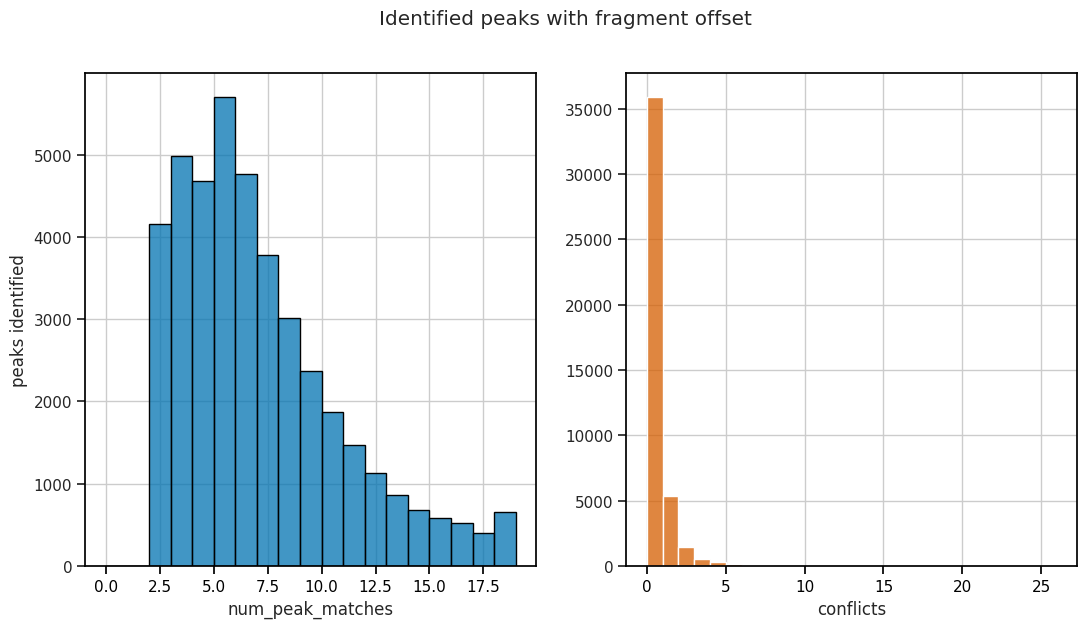

In [ ]:
for stat in df.iloc[0]["Metabolite"].match_stats.keys():
    df[stat] = df["Metabolite"].apply(lambda x: x.match_stats[stat])

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

fig.suptitle(f"Identified peak-fragment matches and number conflicts")
#plt.title(f"Identified peaks with fragment offset: {str(off)}")
sns.histplot(ax=axs[0],data=df, x="num_peak_matches", color=color_palette[0], edgecolor="black", bins=range(0,20, 1))
#axs[0].set_ylim(-0.5, 10)
axs[0].set_ylabel("peaks identified")



sns.histplot(ax=axs[1],data=df, x="num_fragment_conflicts", color=color_palette[3], binwidth=1)
#axs[2].set_ylim(-0.5, 1000)
axs[1].set_xlabel("conflicts")
axs[1].set_ylabel("")

plt.show()

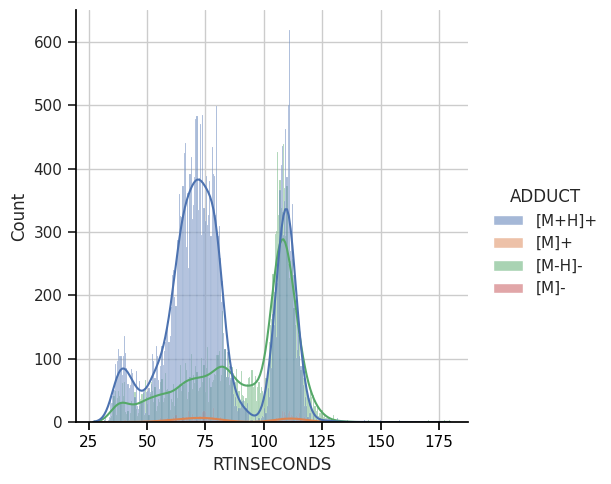

In [ ]:
#df["RETENTIONTIME"] = df["RTINSECONDS"].astype(float)
sns.displot(df, x="RTINSECONDS", kde=True, binwidth=0.5, hue="ADDUCT")
plt.show()

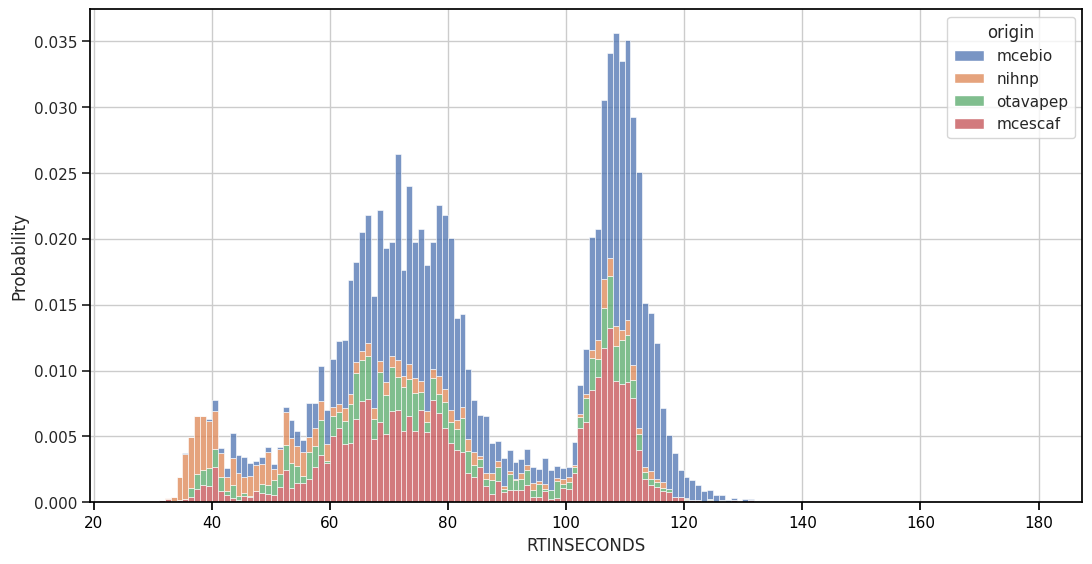

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.histplot(ax=ax, data=df, x="RTINSECONDS", hue='origin', multiple="stack", binwidth=1, stat="probability")
plt.show()

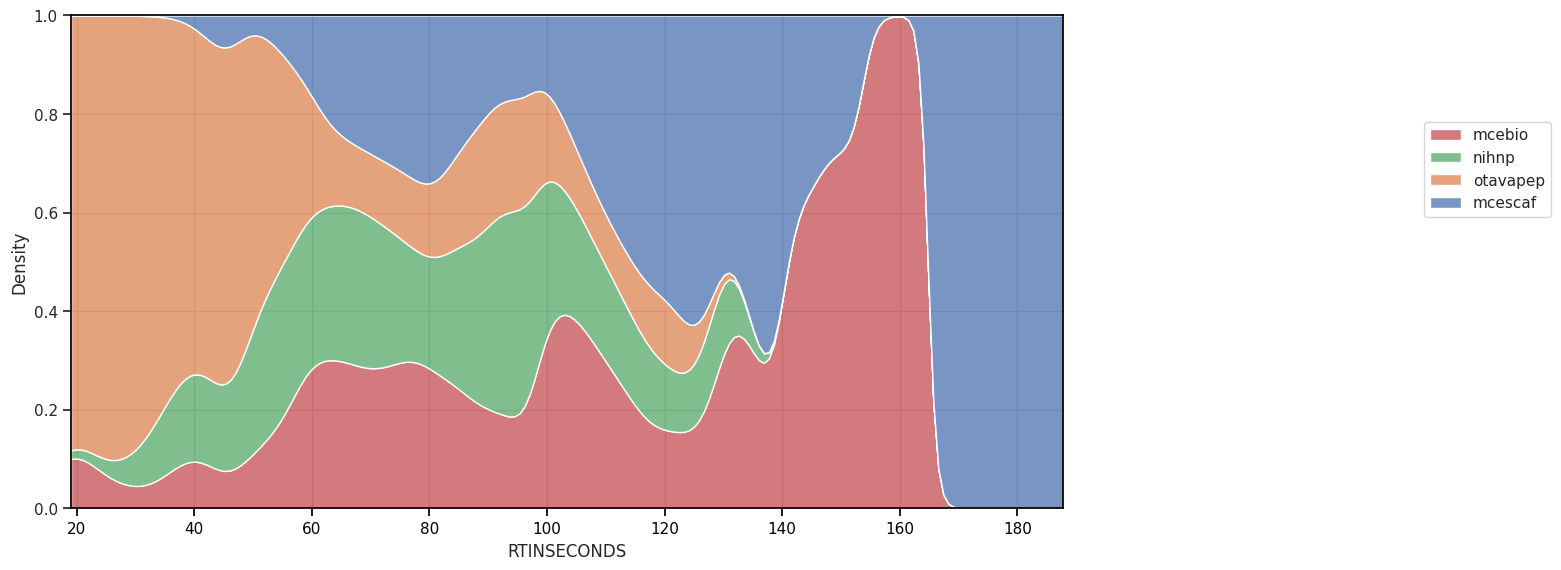

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.kdeplot(ax=ax, data=df, x="RTINSECONDS", hue='origin', multiple="fill", common_norm=False)
ax.legend(bbox_to_anchor=(1.5, 0.8), labels=df["origin"].unique())
plt.show()
    
    